In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [435]:
runs = {
    "a2c_baseline": './runs/a2c_baseline/2020-05-12-15-37/progress2020-05-12-15-37.csv',
    "a2c_pixel_shift": './runs/a2c_pixel_shift/2020-05-09-18-17/progress2020-05-09-18-17.csv',
    "ppo_baseline": './runs/ppo_baseline/2020-05-12-12-18/progress2020-05-12-12-18.csv',
    "ppo_impala": "./runs/ppo_impala/2020-05-10-21-29/progress2020-05-10-21-29.csv",
    "ppo_impala_100": "./runs/ppo_impala_100/2020-05-10-21-56/progress2020-05-10-21-56.csv",
    "ppo_impala_500": "./runs/ppo_impala_500/2020-05-10-21-48/progress2020-05-10-21-48.csv",
    "ppo_impala_pixel_shift": "./runs/ppo_impala_pixel_shift/2020-05-09-18-35/progress2020-05-09-18-35.csv",
    "ppo_impala_augmentation": "./runs/ppo_impala_augmentation/2020-05-10-21-23/progress2020-05-10-21-23.csv"
}

run_mapping = {
    "a2c_baseline": "A2C",
    "a2c_pixel_shift": 'A2C w/ Pixel Shifting',
    "ppo_baseline": 'PPO (Nature CNN) 50 Training Levels',
    "ppo_impala": "PPO (Impala CNN) 50 Training Levels",
    "ppo_impala_100": "PPO (Impala CNN) 100 Training Levels",
    "ppo_impala_500": "PPO (Impala CNN) 500 Training Levels",
    "ppo_impala_pixel_shift": "PPO (Impala CNN) 50 Training Levels w/ Pixel Shifting",
    "ppo_impala_augmentation": "PPO (Impala CNN) 50 Training Levels w/ Full Regularization"
}

In [436]:
runs_pd = {run_mapping[k]: pd.read_csv(v) for k, v in runs.items()}

In [438]:
runs_pd['A2C']['eval_eprewmean'].min()

-4.5

In [433]:
%load_ext autoreload
%autoreload 2

# Ensure your Python version makes sense
import sys
sys.version

import os

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import json, os
import random

# Inspired by CS182 Assigment 4
def plot_single(logdir, trials):
    colors = pl.cm.magma(np.linspace(0,1,len(trials)*2))
    fig = plt.figure(figsize=(20,7))

    for i, path in enumerate(trials):
        name = run_mapping[os.path.normpath(path).split(os.sep)[1]]
        print(name)
        data = pd.read_csv(path)  # in favor of this
        steps_million = data['misc/total_timesteps'] / 1e6
        plt.plot(steps_million, data['eval_eprewmean'], lw=2, color=colors[i*2], alpha=0.1)
        ts_factor = 0.95
        plt.plot(steps_million, data.ewm(alpha=(1 - ts_factor)).mean()["eval_eprewmean"], color=colors[i*2], label=name, )

    # Bells and whistles
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(loc='best', fontsize=14)
    plt.xlabel('Training Steps (in Millions)', fontsize=20)
    plt.ylabel('Average Evaluation Reward', fontsize=20)
    plt.title('Trials', fontsize=20)
    plt.tight_layout()
    plt.savefig('results.png', dpi=600)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


A2C
A2C w/ Pixel Shifting
PPO (Nature CNN) 50 Training Levels
PPO (Impala CNN) 50 Training Levels
PPO (Impala CNN) 100 Training Levels
PPO (Impala CNN) 500 Training Levels
PPO (Impala CNN) 50 Training Levels w/ Pixel Shifting
PPO (Impala CNN) 50 Training Levels w/ Full Regularization


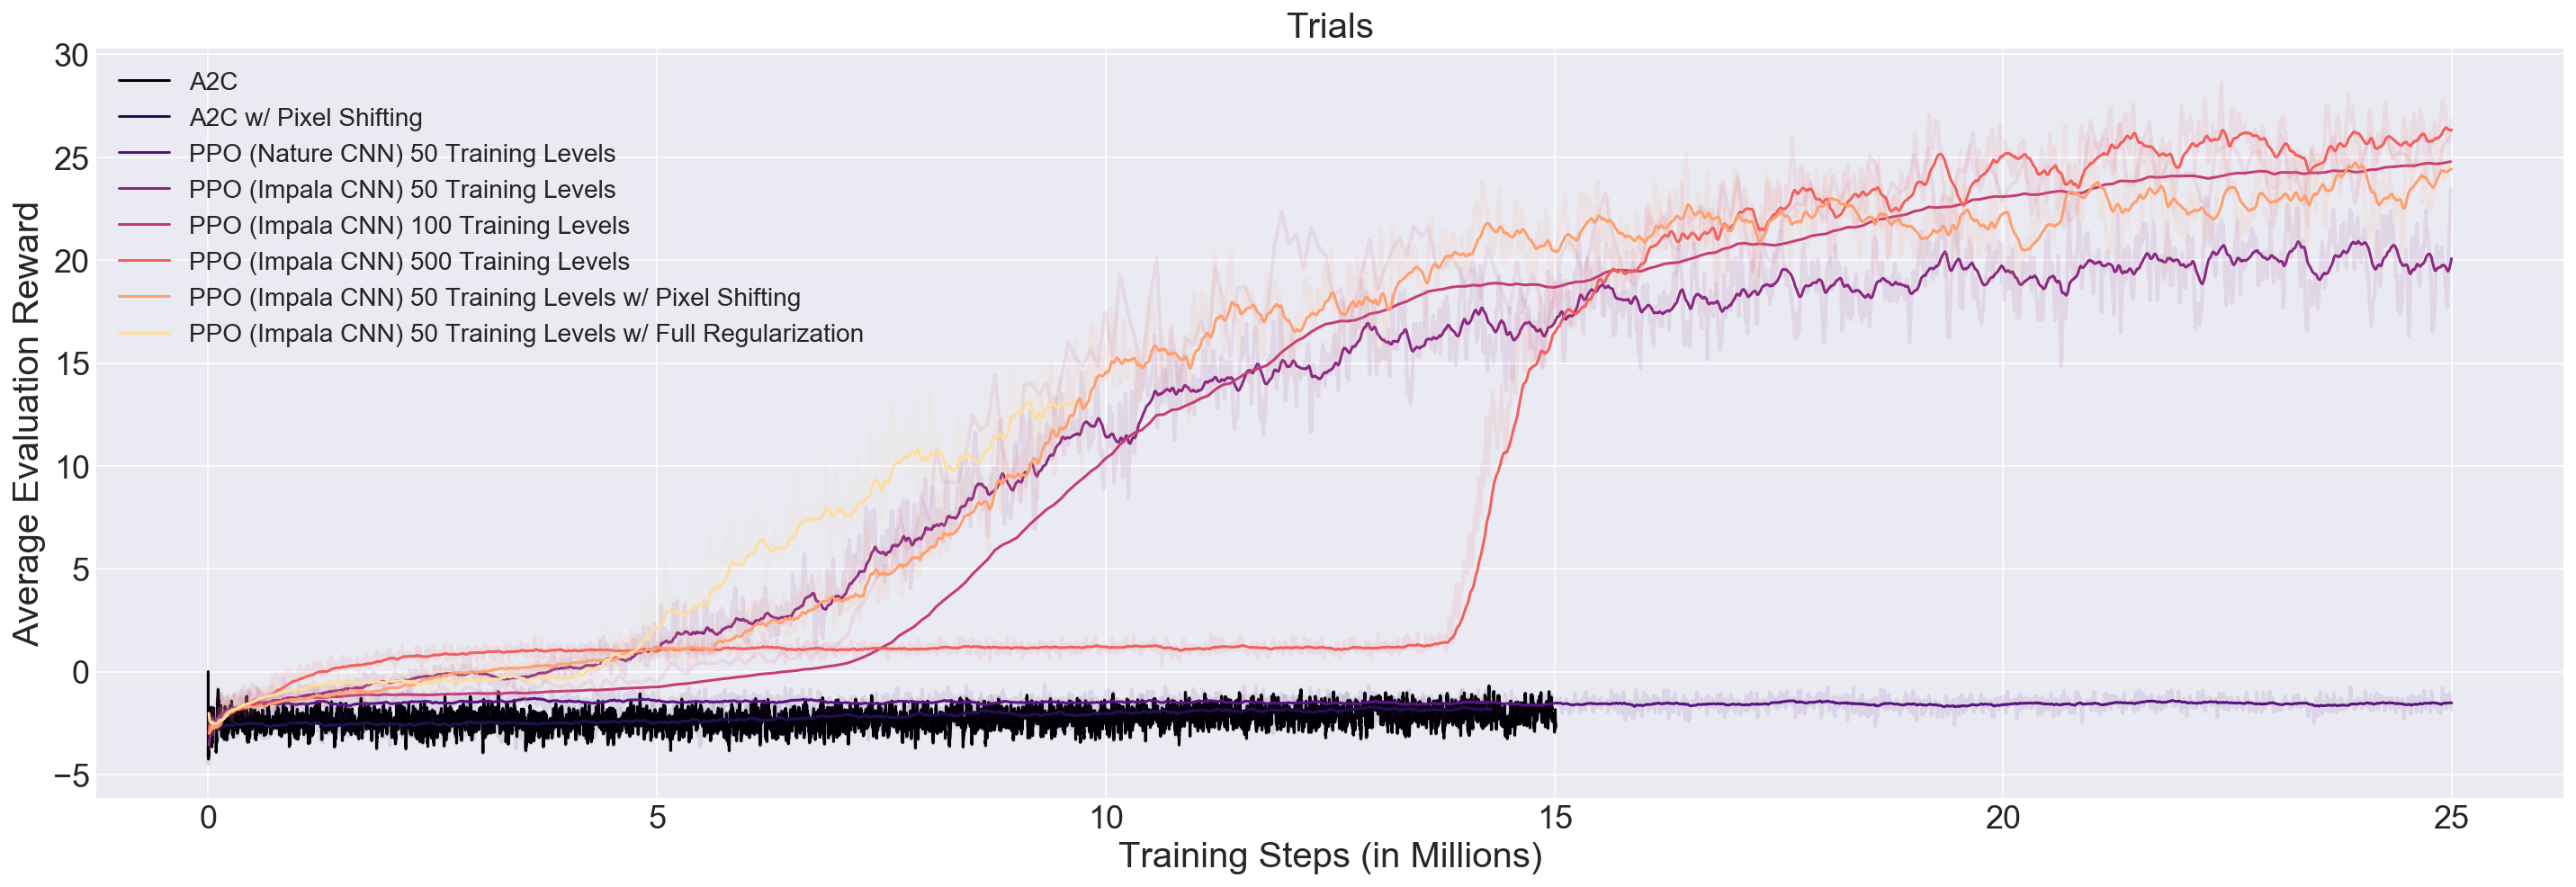

In [434]:
plot_single('', list(runs.values()))

In [400]:
from matplotlib.lines import Line2D
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.4  # the amount of height reserved for white space between subplots
def plot_grid(trials):
    train_color, test_color = pl.cm.magma(0.), pl.cm.magma(.5)
    nrows = 4
    ncols = 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,7))
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for i, path in enumerate(trials):
        name = run_mapping[os.path.normpath(path).split(os.sep)[1]]
        data = pd.read_csv(path)  # in favor of this
        # plot a separate grid for each algo
        row = i // ncols
        col = i % ncols
        steps_million = data['misc/total_timesteps'] / 1e6
        # training
        plot = ax[row][col]
        plot.plot(steps_million, data['eprewmean'], lw=2, color=train_color, alpha=0.1)
        ts_factor = 0.9
        plot.plot(steps_million, data.ewm(alpha=(1 - ts_factor)).mean()["eprewmean"], color=train_color, label=name, )
        # testing
        plot.plot(steps_million, data['eval_eprewmean'], lw=2, color=test_color, alpha=0.1)
        plot.plot(steps_million, data.ewm(alpha=(1 - ts_factor)).mean()["eval_eprewmean"], color=test_color, label=name)
        plot.tick_params(axis='x')
        plot.tick_params(axis='y')
        plot.set(title=name)
        plot.set_ylim([-5, 35])
        
    for i in range(len(trials), nrows * ncols):
        row = i // ncols
        col = i % ncols
        fig.delaxes(ax[row][col])
        
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Training Steps (in Millions)', fontsize=20)
    plt.ylabel('Average Reward', fontsize=20)
    custom_lines = [Line2D([0], [0], color=train_color, lw=4),
                Line2D([0], [0], color=test_color, lw=4)]
    plt.legend(custom_lines, ['Training', 'Testing'], bbox_to_anchor=(1.15, 0.1))
    plt.suptitle('Trials', fontsize=20)
    plt.grid(False)
    plt.savefig('grid_results.png', dpi=600)
    plt.show()

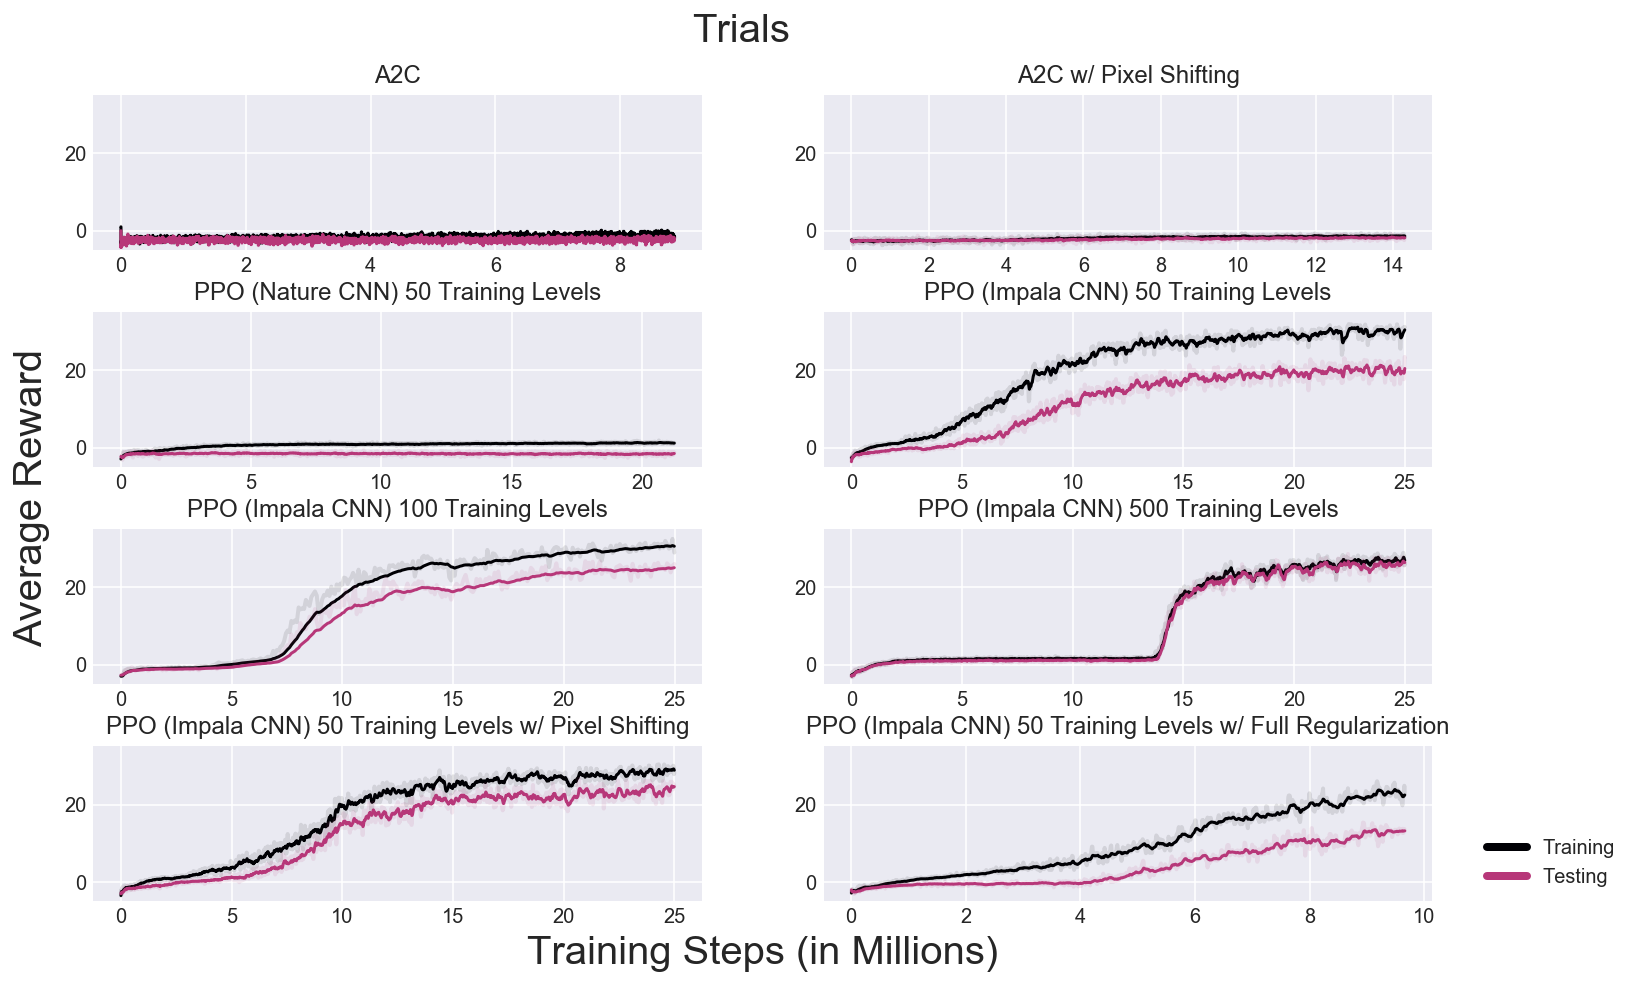

In [401]:
plot_grid(list(runs.values()))

### Test Results (Seed  = 10)

In [424]:
runs = {
    "ppo_impala": "./runs/ppo_impala/2020-05-10-21-29_test/progress2020-05-13-15-59.csv",
    "ppo_impala_100": "./runs/ppo_impala_100/2020-05-10-21-56_test/progress2020-05-13-16-10.csv",
    "ppo_impala_500": "./runs/ppo_impala_500/2020-05-10-21-48_test/progress2020-05-13-16-16.csv",
    "ppo_impala_pixel_shift": "./runs/ppo_impala_pixel_shift/2020-05-09-18-35_test/progress2020-05-13-17-20.csv",
}

run_mapping = {
    "a2c_baseline": "A2C",
    "a2c_pixel_shift": 'A2C w/ Pixel Shifting',
    "ppo_baseline": 'PPO (Nature CNN) 50 Training Levels',
    "ppo_impala": "PPO (Impala CNN) 50 Training Levels",
    "ppo_impala_100": "PPO (Impala CNN) 100 Training Levels",
    "ppo_impala_500": "PPO (Impala CNN) 500 Training Levels",
    "ppo_impala_pixel_shift": "PPO (Impala CNN) 50 Training Levels w/ Pixel Shifting",
    "ppo_impala_augmentation": "PPO (Impala CNN) 50 Training Levels w/ Full Regularization"
}

In [427]:
# Inspired by CS182 Assigment 4
def plot_single(logdir, trials):
    colors = pl.cm.magma(np.linspace(0,1,len(trials)*2))
    fig = plt.figure(figsize=(20,7))

    for i, path in enumerate(trials):
        name = run_mapping[os.path.normpath(path).split(os.sep)[1]]
        data = pd.read_csv(path)  # in favor of this
        steps_million = data['misc/total_timesteps'] / 1e3
        plt.plot(steps_million, data['eprewmean'], lw=2, color=colors[i*2], alpha=1,  label=name)

    # Bells and whistles
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(loc='best', fontsize=14)
    plt.xlabel('Testing Steps (in Thousands))', fontsize=20)
    plt.ylabel('Average Reward', fontsize=20)
    plt.title('Trials', fontsize=20)
    plt.tight_layout()
    plt.savefig('test_results.png', dpi=600)
    plt.show()

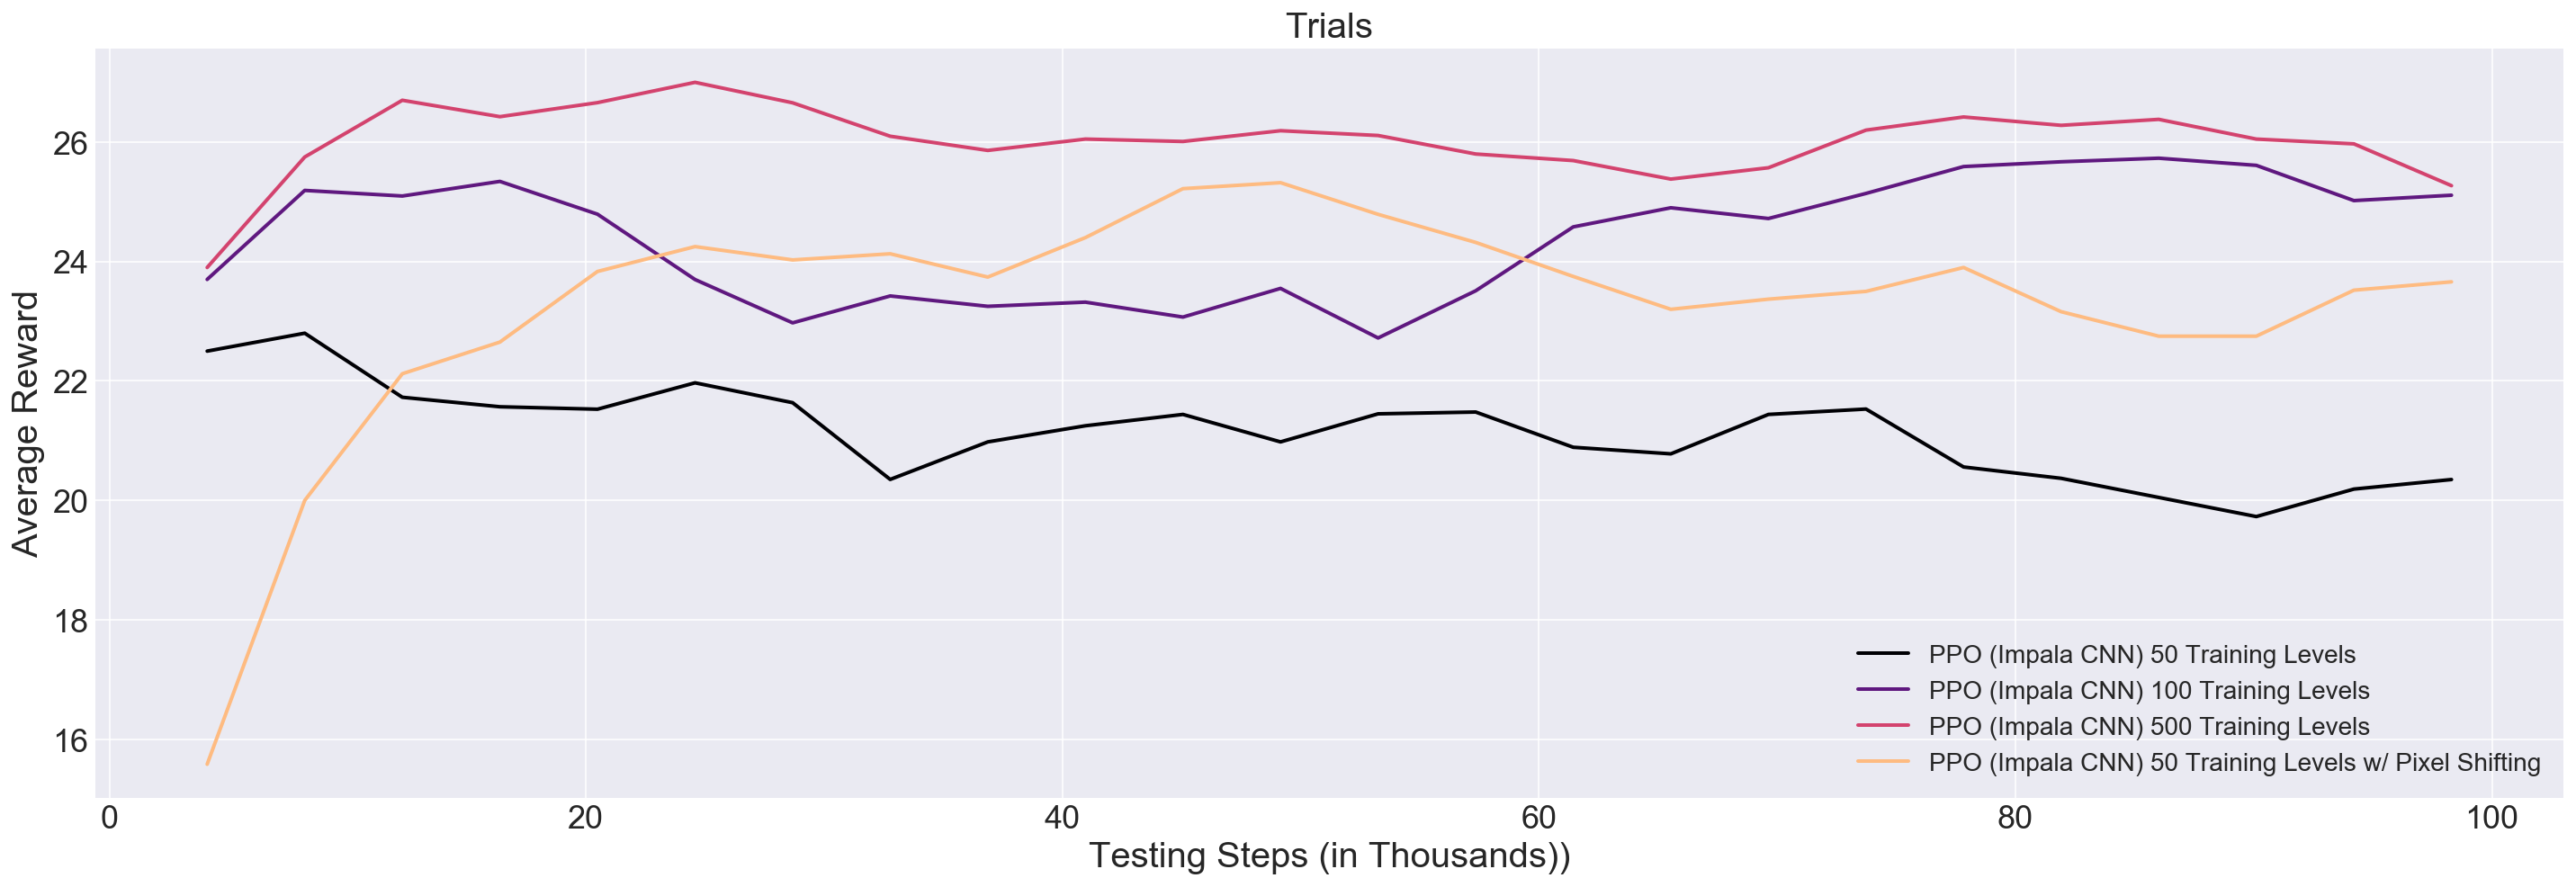

In [428]:
plot_single("", runs.values())